In [19]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

# Import Dataset

In [2]:
df = pd.read_csv('data/raw/train_1.csv', index_col=None)
df.columns = map(str.lower, df.columns) # make column names lowercase

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [4]:
df.sample(5)

,page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
30808,关喆_zh.wikipedia.org_all-access_all-agents,176.0,175.0,167.0,216.0,193.0,170.0,174.0,183.0,187.0,...,119.0,95.0,117.0,106.0,118.0,108.0,102.0,92.0,89.0,108.0
61346,2012年中華民國總統選舉_zh.wikipedia.org_desktop_all-agents,362.0,325.0,220.0,186.0,191.0,295.0,371.0,317.0,237.0,...,59.0,68.0,66.0,75.0,57.0,73.0,89.0,91.0,52.0,67.0
82233,File:Prevailing_world_religions_map_rus.png_co...,78.0,43.0,40.0,82.0,43.0,66.0,74.0,73.0,47.0,...,78.0,81.0,104.0,50.0,82.0,82.0,90.0,82.0,45.0,59.0
109645,Adkhamjon_Ergashev_en.wikipedia.org_all-access...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0
48724,Benedict_Cumberbatch_de.wikipedia.org_all-acce...,3.0,6.0,3.0,5.0,4.0,5.0,30.0,7.0,3.0,...,9.0,10.0,7.0,8.0,12.0,10.0,11.0,12.0,16.0,19.0


#### Extract Language

In [5]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org', page)
    if res:
        return res[0][0:2]
    return 'na'

df['language'] = df.page.map(get_language)

In [6]:
df.sample(3)

,page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,language
19255,Кутья_ru.wikipedia.org_mobile-web_all-agents,29.0,40.0,56.0,40.0,42.0,36.0,47.0,45.0,43.0,...,248.0,551.0,360.0,223.0,178.0,177.0,184.0,203.0,236.0,ru
135376,仲村トオル_ja.wikipedia.org_all-access_spider,1.0,0.0,2.0,5.0,8.0,3.0,14.0,14.0,10.0,...,109.0,46.0,56.0,38.0,39.0,49.0,64.0,71.0,32.0,ja
100558,Аттила_ru.wikipedia.org_all-access_all-agents,617.0,564.0,627.0,719.0,698.0,592.0,569.0,591.0,650.0,...,926.0,1089.0,1109.0,936.0,911.0,837.0,891.0,1110.0,742.0,ru


# Missing Values Interpolation

In [7]:
# Set the index to page and language to maintain structure
df.set_index(['page', 'language'], inplace=True)

# Perform forward linear interpolation
df = df.interpolate(method='linear', limit_direction='forward', axis=0)

# Reset index if needed
df.reset_index(inplace=True)

# Language Analysis

In [8]:
display(Counter(df.language))

Counter({'en': 24108,
         'ja': 20431,
         'de': 18547,
         'na': 17855,
         'fr': 17802,
         'zh': 17229,
         'ru': 15022,
         'es': 14069})

In [9]:
# Melt the dataframe to have a long format
df_melted = df.melt(id_vars=["page", "language"], var_name="date", value_name="views")

# Convert the date column to datetime
df_melted["date"] = pd.to_datetime(df_melted["date"])

# Group by language and date, then sum the views
pivot_df = df_melted.pivot_table(index="date", columns="language", values="views", aggfunc="sum").reset_index()

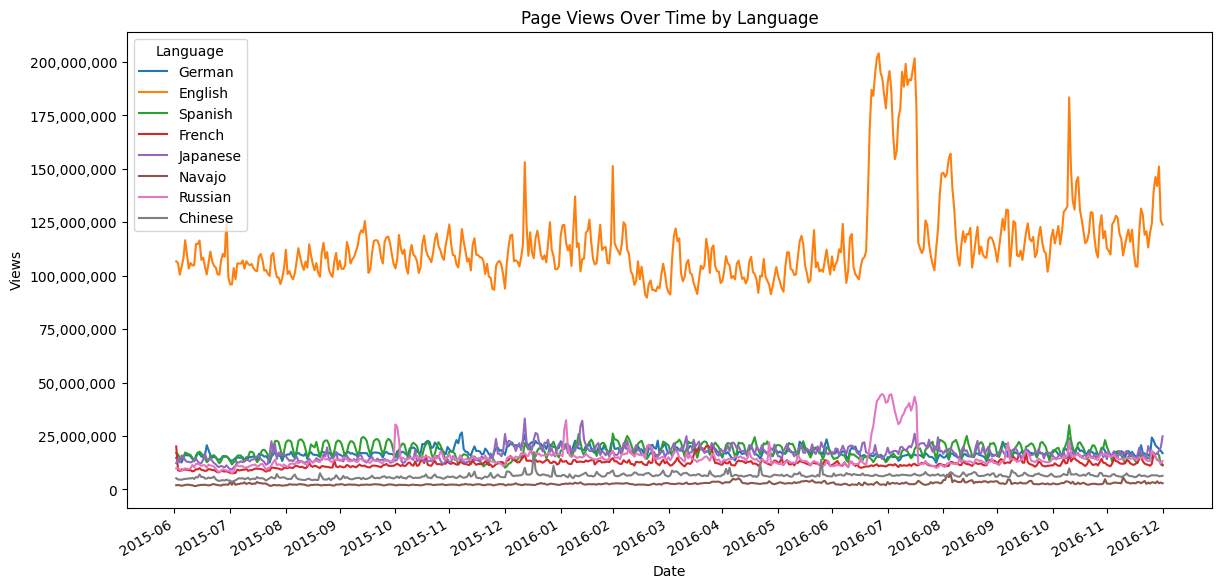

In [20]:
language_names = {
    'en': 'English',
    'ja': 'Japanese',
    'de': 'German',
    'na': 'Navajo',
    'fr': 'French',
    'zh': 'Chinese',
    'ru': 'Russian',
    'es': 'Spanish'
}

plt.figure(figsize=(14, 7))

# Plot each language time series with full names
for language in pivot_df.columns[1:]:
    full_name = language_names.get(language, language)  # Get full name or default to abbreviation
    plt.plot(pivot_df["date"], pivot_df[language], label=full_name)

plt.title("Page Views Over Time by Language")
plt.xlabel("Date")
plt.ylabel("Views")

# Configure x-axis to show ticks every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=-1, interval=1))  # Set locator to every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Set format for tick labels

# Configure y-axis to display full values
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

plt.legend(title="Language")
plt.show()

Insights:
- More English
- English and Russian show very large spikes around August 2016
  - Maybe due to the Summer Olympics and the election in the US
- Spanish has a periodic cycle 

# Weekdays - Weekend Analysis

In [11]:
# Extract day of the week
df_melted['day_of_week'] = df_melted['date'].dt.day_name()

# Calculate the average and standard deviation of views for each day of the week
pivot_table_mean = df_melted.pivot_table(values='views', index='day_of_week', aggfunc='mean')

# Reindex to ensure days are in the correct order
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table_mean = pivot_table_mean.reindex(days_of_week)

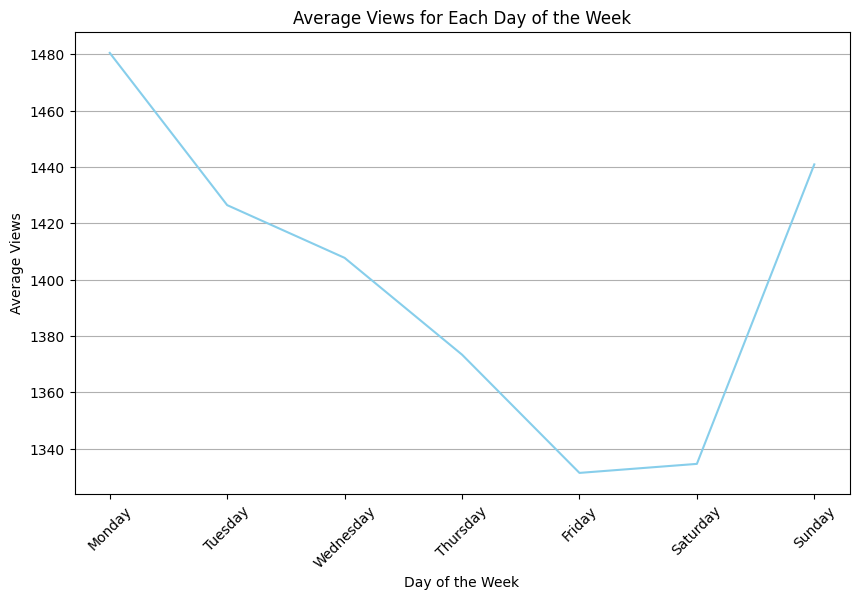

In [12]:
# Plot the average views with standard deviation as error bars
plt.figure(figsize=(10, 6))
plt.plot(pivot_table_mean.index, pivot_table_mean['views'], color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Average Views')
plt.title('Average Views for Each Day of the Week')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()

Insights:
- More views on Monday and Sunday

# Months Analysis

In [13]:
df_melted['month'] = df_melted['date'].dt.month_name()

# Use pivot_table to calculate the average and standard deviation of views for each month
pivot_table = df_melted.pivot_table(values='views', index='month', aggfunc='mean')

# Define the correct order of months
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Reindex to ensure months are in the correct order
pivot_table = pivot_table.reindex(months_order)

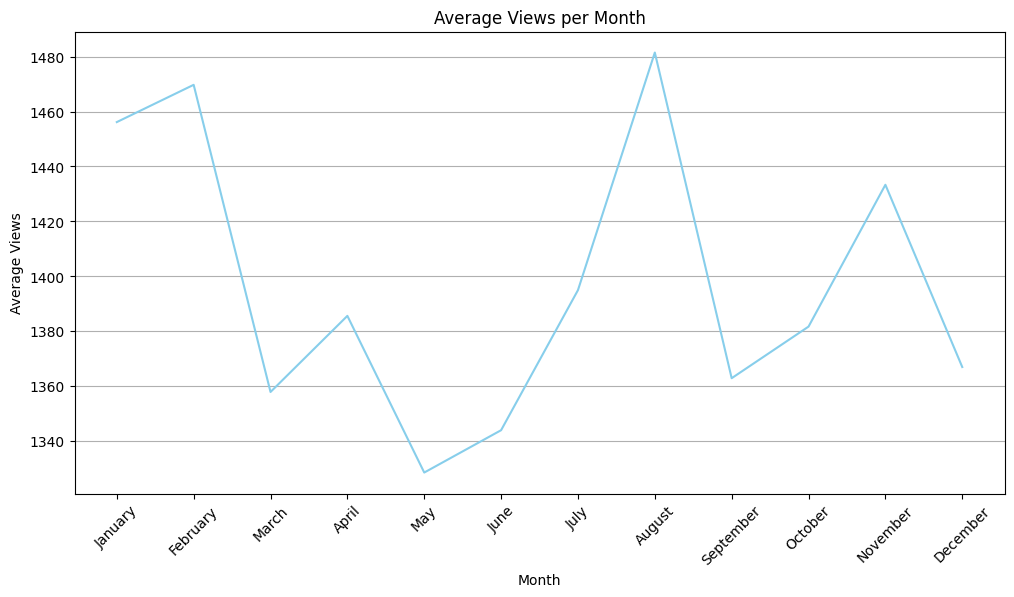

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(pivot_table.index, pivot_table['views'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Views')
plt.title('Average Views per Month')
plt.xticks(rotation=45)
plt.grid(axis='y')

Insights:
- Less during the warmer months, but peak in August due to elections and sports